In [1]:
!pip install lipstick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.datasets import make_moons, make_swiss_roll
from lipstick import GifMaker

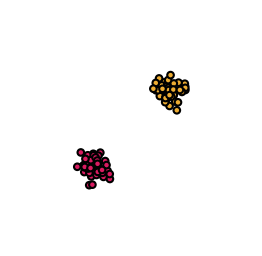

In [3]:
x_0_mog = np.concatenate([
    np.random.normal(loc=-1, scale=0.2, size=(50, 2)),
    np.random.normal(loc=1, scale=0.2, size=(50, 2))
])
x_0_mog = torch.Tensor(x_0_mog)

c_mog = np.concatenate([
    np.zeros((50, )),
    np.ones((50, )),
])

color = ['#D81B60'] * 50 + ['#EDAC32'] * 50

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
ax.scatter(*x_0_mog.T, s=10, c=color, edgecolor='k')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
plt.show()

In [5]:
class NN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = torch.nn.Linear(3, 100)
    self.fc2 = torch.nn.Linear(100, 100)
    self.fc3 = torch.nn.Linear(100, 2)
    self.relu = torch.nn.ReLU()

  def forward(self, x, t):
    inp = torch.cat([x, t.repeat(x.shape[0]).unsqueeze(1)], dim=1)
    out = self.fc1(inp)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    return out

In [6]:
from tqdm import tqdm
mog_net = NN()
optimizer = torch.optim.Adam(mog_net.parameters())

epochs = 5000
pbar = tqdm(range(epochs))

beta = 0.01
alpha = 1 - beta
T = 20
mse = torch.nn.MSELoss()

def get_alpha_bar(alpha, t):
  """
  We assume a constant value of alpha
  """
  return alpha ** t

mog_ls = []
for i in pbar:
  optimizer.zero_grad()

  bs = x_0_mog.shape[0]
  t = torch.randint(0, T, size=(1, ))
  alpha_bar = get_alpha_bar(alpha, T - t)
  eps = torch.randn(bs, 2)
  corrupted_x = torch.sqrt(alpha_bar) * x_0_mog + torch.sqrt(1 - alpha_bar) * eps

  eps_pred = mog_net(corrupted_x, t)

  loss = mse(eps, eps_pred)
  loss.backward()

  optimizer.step()

  mog_ls.append(loss.item())

  pbar.set_description(f'{loss.item():.4f}')

0.1966: 100%|██████████| 5000/5000 [00:32<00:00, 154.77it/s]


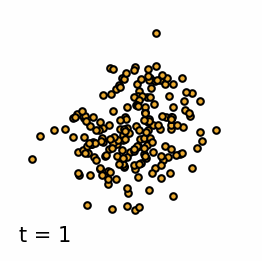

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
x_t = torch.randn(200, 2)

x_mog = x_t.clone()

with GifMaker("diffusion_results.gif", fps=10) as g:
  for t in list(range(1, 20)):
    z = torch.randn(x_t.shape[0], 2)

    x_mog = 1/np.sqrt(alpha) * (x_mog - (1 - alpha)/np.sqrt(1 - get_alpha_bar(alpha, t)) * mog_net(x_mog, torch.Tensor([t])).detach()) + beta * z
    
    
    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs
    ax.scatter(*x_mog.T, s=10, c='#EDAC32', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax.text(-2.9, -2.9, f't = {t}')

    g.add(fig)

  for _ in range(5):
    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs
    ax.scatter(*x_mog.T, s=10, c='#EDAC32', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax.text(-2.9, -2.9, f't = 30')

    g.add(fig)

g.show()

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x, t):
        inp = torch.cat([x, t.repeat(x.shape[0]).unsqueeze(1)], dim=1)
        x = F.relu(self.fc1(inp))
        logits = self.fc2(x)
        return logits

In [17]:
epochs = 500
pbar = tqdm(range(epochs))

beta = 0.01
alpha = 1 - beta
T = 20

cls = Classifier()
optimizer = torch.optim.Adam(cls.parameters())

def get_alpha_bar(alpha, t):
  """
  We assume a constant value of alpha
  """
  return alpha ** t

mog_ls = []
for i in pbar:
  optimizer.zero_grad()

  bs = x_0_mog.shape[0]
  t = torch.randint(0, T, size=(1, ))
  alpha_bar = get_alpha_bar(alpha, T - t)
  eps = torch.randn(bs, 2)
  corrupted_x = torch.sqrt(alpha_bar) * x_0_mog + torch.sqrt(1 - alpha_bar) * eps

  logits = cls(corrupted_x, t)

  # loss = mse(eps, eps_pred)
  loss = F.cross_entropy(logits, F.one_hot(torch.LongTensor(c_mog), 2).float())
  loss.backward()

  optimizer.step()

  mog_ls.append(loss.item())

  pbar.set_description(f'{loss.item():.4f}')

0.0010: 100%|██████████| 500/500 [00:04<00:00, 118.83it/s]


In [34]:
import seaborn as sns
sns.set_context('talk')

plt.figure(figsize=(4, 2), dpi=150)
plt.plot(mog_ls, c='#EDAC32', lw=3)

plt.xticks([0, 250, 500])
plt.ylim(0, 1.5)
plt.xlim(0, 500)

sns.despine(offset=0)

plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')

Text(0, 0.5, 'Cross-Entropy')

In [42]:
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import matplotlib
# matplotlib.rc_file_defaults()

sns.set_context('paper')

x_mog = x_0_mog.clone()
beta = 0.01

with GifMaker("sample.gif", fps=10) as g:
  # fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
  fig = plt.figure(figsize=(6, 2), dpi=150)
  gs = GridSpec(1, 3)


  labels = cls(x_mog, torch.Tensor([0])).argmax(1)

  colors = ['#D81B60', '#EDAC32']
  color_y = np.array([colors[i] for i in labels])

  ax = fig.add_subplot(gs[0, -1])
  ax.text(-2.9, -2.9, f't = {0}', fontsize=10)
  ax.scatter(*x_mog.T, s=10, c=color_y, edgecolor='k', linewidth=1)
  ax.set_xlim(-3, 3)
  ax.set_ylim(-3, 3)
  ax.axis('off')

  ax = fig.add_subplot(gs[0, :-1])
  ax.plot(mog_ls, c='#EDAC32', lw=3)

  ax.set_xticks([0, 250, 500])
  ax.set_ylim(0, 1.5)
  ax.set_xlim(0, 500)

  sns.despine(offset=0)

  ax.set_xlabel('Epochs')
  ax.set_ylabel('Cross-Entropy')

  # ax.set_title('t = 0')

  # ax.text(-2.9, -2.9, 't = 0')

  for _ in range(5):
    g.add(fig)

  for i in tqdm(range(50)):
    x_mog = x_mog * np.sqrt((1 - beta * 2)) + np.sqrt(beta * 2) * torch.randn(len(x_0_mog), 2)

    # fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    fig = plt.figure(figsize=(6, 2), dpi=150)
    gs = GridSpec(1, 3)

    labels = cls(x_mog, torch.Tensor([i + 1])).argmax(1)

    colors = ['#D81B60', '#EDAC32']
    color_y = np.array([colors[i] for i in labels])

    ax = fig.add_subplot(gs[0, -1])
    ax.text(-2.9, -2.9, f't = {i + 1}', fontsize=10)
    ax.scatter(*x_mog.T, s=10, c=color_y, edgecolor='k', linewidth=1)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax = fig.add_subplot(gs[0, :-1])
    ax.plot(mog_ls, c='#EDAC32', lw=3)

    ax.set_xticks([0, 250, 500])
    ax.set_ylim(0, 1.5)
    ax.set_xlim(0, 500)

    sns.despine(offset=0)

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cross-Entropy')

      # ax.set_title(f't = {i + 1}')
  
    g.add(fig)

g.show()

100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


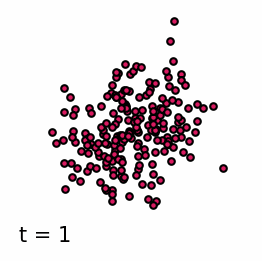

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
x_t = torch.randn(200, 2)

x_mog = x_t.clone()

def condition_grad(cls, x, y, s=3):
  x_in = x_mog.detach().requires_grad_(True)

  logits = cls(x_in, torch.Tensor([t]))
  log_probs = F.log_softmax(logits, dim=-1)
  selected = log_probs[range(len(logits)), torch.LongTensor([y]).view(-1)]
  
  grad = torch.autograd.grad(selected.sum(), x_in)[0] * s
  
  return grad

with GifMaker("diffusion_results.gif", fps=10) as g:
  for t in list(range(1, 30)):
    z = torch.randn(x_t.shape[0], 2)

    grad = condition_grad(cls, x_mog, 0)

    eps = mog_net(x_mog, torch.Tensor([t])).detach() - np.sqrt(1 - get_alpha_bar(alpha, t)) * grad
    x_mog = 1/np.sqrt(alpha) * (x_mog - (1 - alpha)/np.sqrt(1 - get_alpha_bar(alpha, t)) * eps) + beta * z

    
    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs
    ax.scatter(*x_mog.T, s=10, c='#D81B60', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax.text(-2.9, -2.9, f't = {t}')

    g.add(fig)

  for _ in range(5):
    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs
    ax.scatter(*x_mog.T, s=10, c='#D81B60', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax.text(-2.9, -2.9, f't = 30')

    g.add(fig)

g.show()

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
x_t = torch.randn(200, 2)

x_mog = x_t.clone()

with GifMaker("diffusion_results.gif", fps=10) as g:
  for t in list(range(1, 30)):
    z = torch.randn(x_t.shape[0], 2)

    grad = condition_grad(cls, x_mog, 1)

    eps = mog_net(x_mog, torch.Tensor([t])).detach() - np.sqrt(1 - get_alpha_bar(alpha, t)) * grad
    x_mog = 1/np.sqrt(alpha) * (x_mog - (1 - alpha)/np.sqrt(1 - get_alpha_bar(alpha, t)) * eps) + beta * z

    
    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs
    ax.scatter(*x_mog.T, s=10, c='#EDAC32', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax.text(-2.9, -2.9, f't = {t}')

    g.add(fig)

  for _ in range(5):
    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs
    ax.scatter(*x_mog.T, s=10, c='#EDAC32', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax.text(-2.9, -2.9, f't = 30')

    g.add(fig)

g.show()

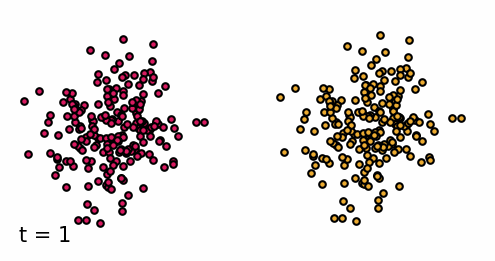

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file_defaults()
x_t = torch.randn(200, 2)

x_mog = x_t.clone()
x_mog_0 = x_t.clone()
x_mog_1 = x_t.clone()

def condition_grad(cls, x, y, s=3):
  x_in = x.detach().requires_grad_(True)

  logits = cls(x_in, torch.Tensor([t]))
  log_probs = F.log_softmax(logits, dim=-1)
  selected = log_probs[range(len(logits)), torch.LongTensor([y]).view(-1)]
  
  grad = torch.autograd.grad(selected.sum(), x_in)[0] * s
  
  return grad

with GifMaker("diffusion_guided_results.gif", fps=10) as g:
  for t in list(range(1, 30)):
    z = torch.randn(x_t.shape[0], 2)

    grad_0 = condition_grad(cls, x_mog_0, 0, 3)
    grad_1 = condition_grad(cls, x_mog_1, 1, 3)

    eps_0 = mog_net(x_mog_0, torch.Tensor([t])).detach() - np.sqrt(1 - get_alpha_bar(alpha, t)) * grad_0
    eps_1 = mog_net(x_mog_1, torch.Tensor([t])).detach() - np.sqrt(1 - get_alpha_bar(alpha, t)) * grad_1
    x_mog_0 = 1/np.sqrt(alpha) * (x_mog_0 - (1 - alpha)/np.sqrt(1 - get_alpha_bar(alpha, t)) * eps_0) + beta * z
    x_mog_1 = 1/np.sqrt(alpha) * (x_mog_1 - (1 - alpha)/np.sqrt(1 - get_alpha_bar(alpha, t)) * eps_1) + beta * z

    
    fig, axs = plt.subplots(1, 2, figsize=(4, 2), dpi=150)
    ax = axs[0]
    ax.scatter(*x_mog_0.T, s=10, c='#D81B60', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax.text(-2.9, -2.9, f't = {t}')

    ax = axs[1]
    ax.scatter(*x_mog_1.T, s=10, c='#EDAC32', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    g.add(fig)

  for _ in range(5):
    fig, axs = plt.subplots(1, 2, figsize=(4, 2), dpi=150)
    ax = axs[0]
    ax.scatter(*x_mog_0.T, s=10, c='#D81B60', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    ax.text(-2.9, -2.9, f't = 30')

    ax = axs[1]
    ax.scatter(*x_mog_1.T, s=10, c='#EDAC32', edgecolor='k')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')

    g.add(fig)

g.show()

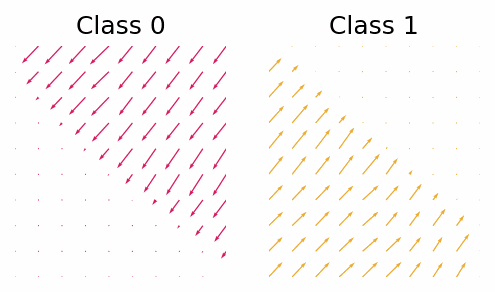

In [78]:
matplotlib.rc_file_defaults()
import numpy as np

# sns.set_context('talk')

N = 10
x = np.stack(np.meshgrid(np.linspace(-3, 3, N), np.linspace(-3, 3, N)), -1)
x = x.reshape(-1, 2)
x = torch.Tensor(x)

with GifMaker("classifier_gradient.gif", fps=10) as g:
  for t in list(range(1, 30)):
    grad_0 = condition_grad(cls, x, 0, 1)
    grad_1 = condition_grad(cls, x, 1, 1)

    fig, axs = plt.subplots(1, 2, figsize=(4, 2), dpi=150)
    ax = axs[0]

    ax.quiver(x[..., 0], x[..., 1], grad_0[..., 0], grad_0[..., 1], color='#D81B60')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    ax.set_title('Class 0')

    ax = axs[1]

    ax.quiver(x[..., 0], x[..., 1], grad_1[..., 0], grad_1[..., 1], color='#EDAC32')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    ax.set_title('Class 1')

    g.add(fig)

  # for _ in range(5):
  #   g.add(fig)

g.show()

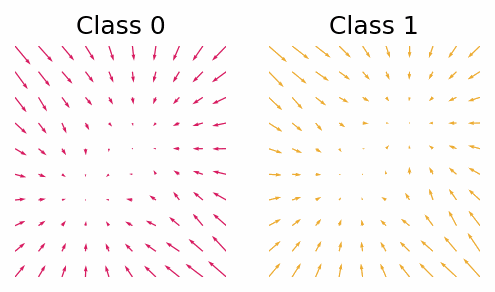

In [82]:
matplotlib.rc_file_defaults()
import numpy as np

# sns.set_context('talk')

N = 10
x = np.stack(np.meshgrid(np.linspace(-3, 3, N), np.linspace(-3, 3, N)), -1)
x = x.reshape(-1, 2)
x = torch.Tensor(x)

with GifMaker("guided_diffusion_gradient.gif", fps=10) as g:
  for t in list(range(1, 30)):
    grad_0 = condition_grad(cls, x, 0, 3)
    grad_1 = condition_grad(cls, x, 1, 3)

    eps_0 = mog_net(x, torch.Tensor([t])).detach() - np.sqrt(1 - get_alpha_bar(alpha, t)) * grad_0
    eps_1 = mog_net(x, torch.Tensor([t])).detach() - np.sqrt(1 - get_alpha_bar(alpha, t)) * grad_1

    fig, axs = plt.subplots(1, 2, figsize=(4, 2), dpi=150)
    ax = axs[0]

    ax.quiver(x[..., 0], x[..., 1], -eps_0[..., 0], -eps_0[..., 1], color='#D81B60')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    ax.set_title('Class 0')

    ax = axs[1]

    ax.quiver(x[..., 0], x[..., 1], -eps_1[..., 0], -eps_1[..., 1], color='#EDAC32')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    ax.set_title('Class 1')

    g.add(fig)

  # for _ in range(5):
  #   g.add(fig)

g.show()

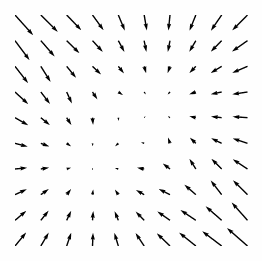

In [46]:
matplotlib.rc_file_defaults()
import numpy as np

# sns.set_context('talk')

N = 10
x = np.stack(np.meshgrid(np.linspace(-3, 3, N), np.linspace(-3, 3, N)), -1)
x = x.reshape(-1, 2)
x = torch.Tensor(x)

with GifMaker("diffusion_results_gradient.gif", fps=10) as g:
  for t in list(range(1, 30)):
    x_in = x.detach().requires_grad_(True)
    logits = cls(x_in, torch.Tensor([t]))
    log_probs = F.log_softmax(logits, dim=-1)
    selected = log_probs[range(len(logits)), torch.LongTensor([0]).view(-1)]
    grad = torch.autograd.grad(selected.sum(), x_in)[0] * 2

    eps = mog_net(x, torch.Tensor([t])).detach() - np.sqrt(1 - get_alpha_bar(alpha, t)) * grad
    eps = -eps

    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs

    ax.quiver(x[..., 0], x[..., 1], eps[..., 0], eps[..., 1])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    g.add(fig)

  # for _ in range(5):
  #   g.add(fig)

g.show()

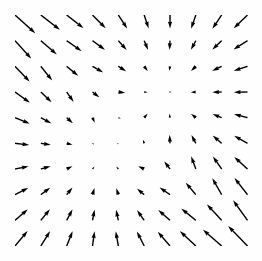

In [47]:
matplotlib.rc_file_defaults()
import numpy as np

# sns.set_context('talk')

N = 10
x = np.stack(np.meshgrid(np.linspace(-3, 3, N), np.linspace(-3, 3, N)), -1)
x = x.reshape(-1, 2)
x = torch.Tensor(x)

with GifMaker("diffusion_results_gradient.gif", fps=10) as g:
  for t in list(range(1, 30)):
    x_in = x.detach().requires_grad_(True)
    logits = cls(x_in, torch.Tensor([t]))
    log_probs = F.log_softmax(logits, dim=-1)
    selected = log_probs[range(len(logits)), torch.LongTensor([1]).view(-1)]
    grad = torch.autograd.grad(selected.sum(), x_in)[0] * 2

    eps = mog_net(x, torch.Tensor([t])).detach() - np.sqrt(1 - get_alpha_bar(alpha, t)) * grad
    eps = -eps

    fig, axs = plt.subplots(1, 1, figsize=(2, 2), dpi=150)
    ax = axs

    ax.quiver(x[..., 0], x[..., 1], eps[..., 0], eps[..., 1])
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.axis('off')
    g.add(fig)

  # for _ in range(5):
  #   g.add(fig)

g.show()